Importing all required libraries

In [24]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import deque,namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [25]:
EPISODES = 1000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = (EPSILON_START-EPSILON_END)/EPISODES
LR = 1e-4
BATCH_SIZE = 64
GAMMA = 0.99
X = 100

In [26]:
env = gym.make('CartPole-v1')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

Transition = namedtuple('Transition',['state','action','next_state','reward','done'])
class ReplayBuffer(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen = capacity)

    def push(self,*args):
        self.memory.append(Transition(*args))
    
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    
    def len(self):
        return len(self.memory)

class DQNPolicy(nn.Module):

    def __init__(self,n_observations,n_actions):
        super(DQNPolicy,self).__init__()
        self.layer1 = nn.Linear(n_observations,128) #fully connect layer with n_observation neurons connected with 128 neurons
        self.layer2 = nn.Linear(128,128) #fully connect layer with 128 neurons connected with 128 neurons
        self.layer3 = nn.Linear(128,n_actions) #fully connect layer with 128 neurons connected with n_action neurons
    
    #passes it through the 3 layer neural network
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQNTarget(nn.Module):

    def __init__(self,n_observations,n_actions):
        super(DQNTarget,self).__init__()
        self.layer1 = nn.Linear(n_observations,128) #fully connect layer with n_observation neurons connected with 128 neurons
        self.layer2 = nn.Linear(128,128) #fully connect layer with 128 neurons connected with 128 neurons
        self.layer3 = nn.Linear(128,n_actions) #fully connect layer with 128 neurons connected with n_action neurons
    
    #passes it through the 3 layer neural network
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def update_target(policy_net,target_net):
    target_net.load_state_dict(policy_net.state_dict())
    
def loss(states,actions,next_states,rewards,dones):
    with torch.no_grad():  # Detach target computation from gradient graph
        next_q_values = target_net(next_states)
        max_next_q = next_q_values.max(1)[0]  # Max Q-value for next state
        target_q = rewards + (GAMMA * max_next_q * (1 - dones))  # Handle terminal states
    current_q = policy_net(states).gather(1, actions)  # Q(s,a) for taken actions
    loss = F.mse_loss(current_q, target_q.unsqueeze(1))  # Mean Squared Error
    optimizer.zero_grad()
    loss.backward()  # Compute gradients
    optimizer.step()  # Update policy_net's parameters (θ)

  

n_actions = env.action_space.n
state,info = env.reset()
n_observations = len(state)

policy_net = DQNPolicy(n_observations,n_actions).to(device)
target_net = DQNTarget(n_observations,n_actions).to(device)
update_target(policy_net,target_net)

optimizer = optim.Adam(policy_net.parameters(),lr = LR,amsgrad=True)
memory = ReplayBuffer(1000)




Accuracy : 0.162


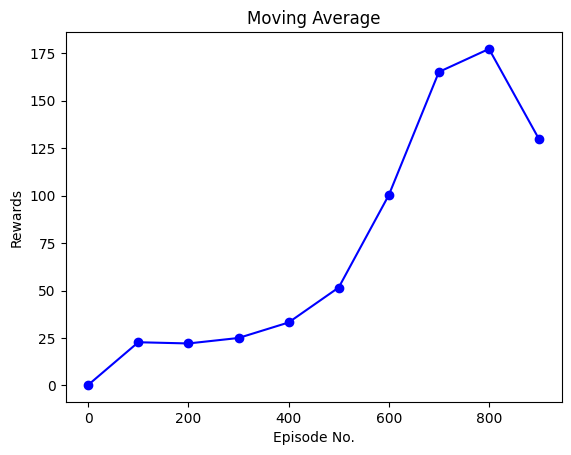

In [27]:
counter = 0
total = 0
count = 0
averages = []
episode = []
for i in range(EPISODES):
    done = False
    sum = 0
    state,info = env.reset()
    epsilon = EPSILON_START - EPSILON_DECAY*i
    state = torch.tensor(state, dtype = torch.float32, device = device).unsqueeze(0)
    while not done:
        counter += 1
        if random.random()<epsilon:
            action = torch.tensor([[env.action_space.sample()]],device= device, dtype = torch.long)
        else:
            action = policy_net(state).max(1)[1].view(1,1)
        observation,reward,terminated,truncated,info = env.step(action.item())
        sum += reward
        reward = torch.tensor([reward],device = device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation,dtype = torch.float32,device = device).unsqueeze(0)
        memory.push(state,action,next_state,reward,done)
        state = next_state
        if(counter >= BATCH_SIZE):
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))

            state_batch = torch.cat(batch.state).to(device)
            action_batch = torch.cat(batch.action).to(device)
            reward_batch = torch.cat(batch.reward).to(device)
            
            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)),
                device=device, dtype=torch.bool
            )
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
            
            with torch.no_grad():
                next_q_values = torch.zeros(BATCH_SIZE, device=device)
                next_q_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
                
            current_q = policy_net(state_batch).gather(1, action_batch)
            expected_q = (next_q_values * GAMMA) + reward_batch
            
            loss = F.mse_loss(current_q, expected_q.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()
    total += sum
    if(sum>=195):
        count+=1
    if(i%(EPISODES/10) == 0):
        averages.append(total*10/EPISODES)
        episode.append(i)
        total = 0
    if(i%X == 0):
        update_target(policy_net,target_net)
print(f'Accuracy : {count/EPISODES}')   
plt.plot(episode,averages,marker = 'o', c = 'b')
plt.xlabel('Episode No.')
plt.ylabel('Rewards')
plt.title('Moving Average')
plt.show()    

        